In [ ]:
# SPDX-FileCopyrightText: 2024 Universidad Autónoma de Madrid, Madrid (Spain)
# SPDX-License-Identifier: EUPL-1.2

"""
This script performs step-by-step spectral extraction, applying the wavelength ratio, a quality filter, and creating spectral groups.
The user can process one (previosuly calibrated) hyperspectral image at a time.

Written by: Claudia Fournier
Revised date: 24.10.2024
"""

# Load the libraries

In [ ]:
from spectral import open_image, imshow  # For handling hyperspectral images
import spectral                          # General import of spectral library functions
import matplotlib.pyplot as plt           # For plotting and visualization
import pandas as pd                       # For data handling and manipulation
import numpy as np                        # For numerical operations and array manipulation
import os                                 # For file path and directory handling

# Load the data

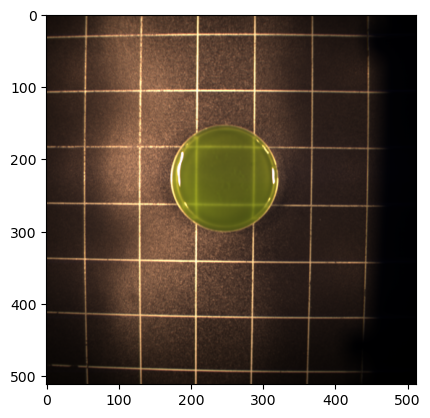

In [90]:
# Set the base path and define the directory of the calibrated image
base_path = os.getcwd()
img_path = os.path.join(base_path, "data", "calibrated", "003", "003_calibrated.hdr")

# Check if the image path exists
if os.path.exists(img_path):
    # Load the image
    img = open_image(img_path)
    # Display calibrated image
    imshow(img, (86, 52, 18))
else:
    print(f"Error: The file {img_path} does not exist.")

# Create the mask for spectral extraction 

<Figure size 1000x800 with 0 Axes>

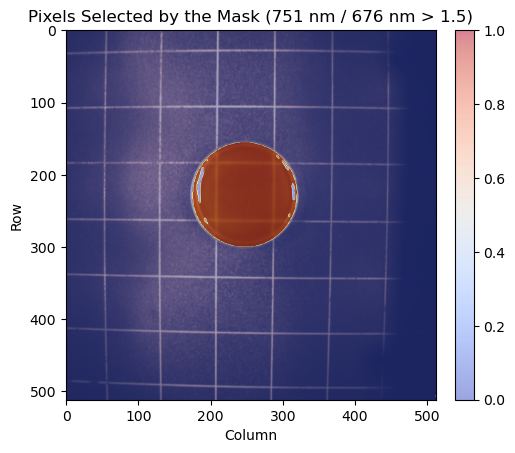

In [72]:
# Create the mask for pixels with a 751 nm / 676 nm ratio above 1.5

# Find indices for the 751 nm and 676 nm wavelengths
wavelength_751_index = int(np.argmin(np.abs(wavelengths - 751)))
wavelength_676_index = int(np.argmin(np.abs(wavelengths - 676)))

# Compute the ratio between these two wavelengths
ratio_image = img[:, :, wavelength_751_index] / img[:, :, wavelength_676_index]

# Define the threshold for creating the mask
threshold = 1.5
mask = ratio_image > threshold

# Plot the mask overlayed on the calibrated image
plt.figure(figsize=(10, 8))

# Display the calibrated image with the selected bands (Red: 650 nm, Green: 550 nm, Blue: 450 nm)
spectral.imshow(img, (86, 52, 18))

# Overlay the mask with a coolwarm colormap
mask_overlay = plt.imshow(mask, cmap='coolwarm', alpha=0.5)

# Add a color bar for the mask overlay
cbar = plt.colorbar(mask_overlay, fraction=0.046, pad=0.04)

# Add title and axis labels
plt.title('Pixels Selected by the Mask (751 nm / 676 nm > 1.5)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.grid(False)

plt.show()

# Spectral extraction and quality filter

## Spectral extraciton
Create dataframe with pixels in rows and wavelengths in columns

In [79]:
# Convert boolean mask to integer indices
indices = np.argwhere(mask)

# Extract spectra using the spectral library
spectra_data = []
for idx in indices:
    x, y = idx[0], idx[1]
    spectra = img[x, y, :]  # Access spectra at position (x, y)
    spectra_data.append(spectra)
    
# Convert spectra data to a NumPy array and reshape
spectra_data = np.array(spectra_data).reshape(len(spectra_data), -1)

# Create wavelength column names with decimals included
wavelength_columns = [f"{wavelength:.2f}" for wavelength in wavelengths]

# Create DataFrame with spectra_data and wavelength_columns
df = pd.DataFrame(spectra_data, columns=wavelength_columns)

# Verify the number of pixels in the mask and rows in the DataFrame
num_pixels_mask = np.count_nonzero(mask)
num_rows_df = len(df)

# Compare the numbers
if num_pixels_mask == num_rows_df:
    print("Number of pixels in mask and number of rows in df are the same.")
else:
    print("Number of pixels in mask and number of rows in df are different.")

Number of pixels in mask and number of rows in df are the same.


## Applying a quality filter

All rows with mean reflectance below 0.01 are removed

In [54]:
# Calculate the mean reflectance for each row
row_means = df.mean(axis=1)

# Filter the DataFrame to keep only rows with mean reflectance >= 0.01
filtered_df = df[row_means >= 0.01]

# Calculate the number of rows removed
rows_removed = df.shape[0] - filtered_df.shape[0]

# Reset the index of the filtered DataFrame
filtered_df = filtered_df.reset_index(drop=True)

print(f"Original number of rows: {df.shape[0]}")
print(f"Number of rows after filtering: {filtered_df.shape[0]}")
print(f"{rows_removed} rows were removed.")

Original number of rows: 16127
Number of rows after filtering: 16126
1 rows were removed.


## Creating spectral groups

### Randomly shuffeling and averaging

In [81]:
# Ensure reproducibility
np.random.seed(42)

# Number of rows to average in each group
group_size = 20  # Set to desired group size (e.g., 20). Increasing group size reduces total rows in the output.

# Calculate the number of groups
num_groups = len(filtered_df) // group_size

# Randomly shuffle the rows
shuffled_df = filtered_df.sample(frac=1).reset_index(drop=True)

# Initialize a list to store the averaged rows
averaged_rows = []

# Loop through each group and calculate the average
for i in range(num_groups):
    group = shuffled_df.iloc[i * group_size : (i + 1) * group_size]
    averaged_row = group.mean(axis=0)
    averaged_rows.append(averaged_row)

# Convert the list of averaged rows to a DataFrame
averaged_df_shuffled = pd.DataFrame(averaged_rows)

# Print the number of rows in the original and the averaged DataFrame
print(f"Original number of rows: {len(filtered_df)}")
print(f"Number of rows after averaging every {group_size} rows: {len(averaged_df_shuffled)}")

Original number of rows: 16126
Number of rows after averaging every 20 rows: 806


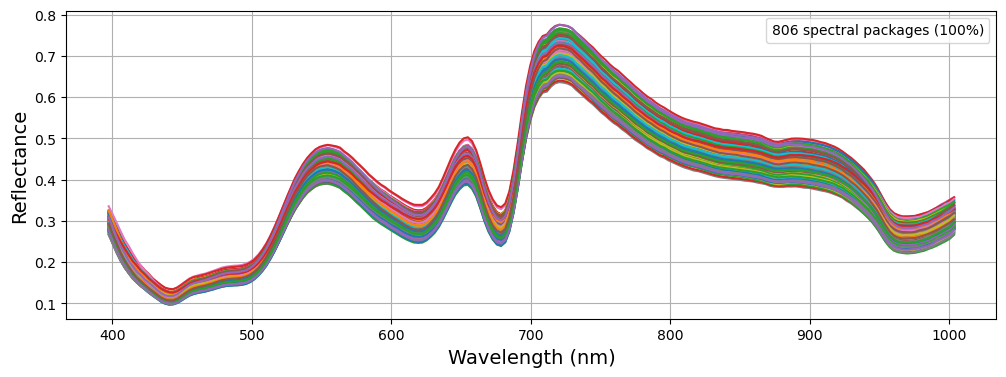

In [84]:
# Plot the spectra for all rows in the DataFrame
plt.figure(figsize=(12, 4))  # Increase the width and height of the figure

for idx in range(len(averaged_df_shuffled)):  # Plot all rows
    plt.plot(wavelengths, averaged_df_shuffled.iloc[idx])

plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('')

# Add a custom legend with only the message (number of spectral packages, no lines)
num_spectra = len(averaged_df_shuffled)
plt.legend([f'{num_spectra} spectral packages (100%)'], loc='upper right', handlelength=0, handletextpad=0)

plt.grid(True)

plt.show()

### Selection of 3% of averaged spectra

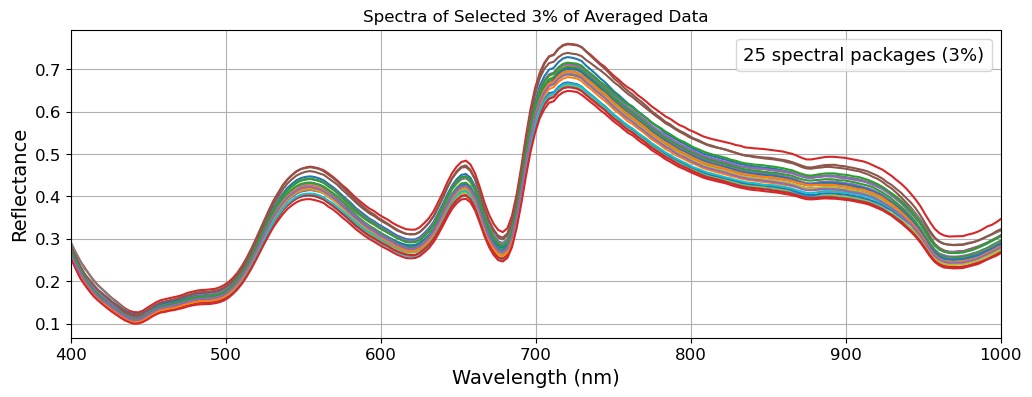

In [88]:
# Calculate 3% of the total number of rows
num_rows = int(np.ceil(len(averaged_df_shuffled) * 0.03))

# Select the first 3% of rows from the shuffled and averaged data
df_3 = averaged_df_shuffled.iloc[:num_rows]

# Plot the spectra for the calculated 3% of rows
plt.figure(figsize=(12, 4))  # Set the figure size

# Plot each row in the selected 3%
for idx in range(num_rows):  
    plt.plot(wavelengths, df_3.iloc[idx])

# Label the axes and add a title
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectra of Selected 3% of Averaged Data')

# Add a custom legend with a message about the selection
plt.legend([f'{num_rows} spectral packages (3%)'], loc='upper right', handlelength=0, handletextpad=0, fontsize=13)

# Customize tick labels and set wavelength range
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(400, 1000)
plt.grid(True)

plt.show()